## Dicom windowing

This notebook assumes `cache/train_folds8_seed300.pkl` exists.
Please make sure to run `bin/preprocess.sh` before running this notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>")) 

import sys
import os
import pickle

import cv2
import pydicom
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('../')))
from src.utils import misc
from src.cnn import factory
from src.cnn.dataset.custom_dataset import apply_window_policy

### Load dataframe which includes parsed meta data associated with ID

In [2]:
with open('../cache/train_folds8_seed300.pkl', 'rb') as f:
    train = pickle.load(f)
print(train.shape)
train.head()

(743775, 16)


,ID,labels,PatientID,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,Position3,PositionOrd,LeftLabel,RightLabel,BitsStored,PixelRepresentation,brain_ratio,brain_diff,fold
199747,ID_000012eaf,,ID_f15c0eee,30,80,-1024.0,1.0,77.970825,0.281250,,,16,1,0.223640,80.0,7
93697,ID_000039fa0,,ID_eeaf99e7,30,80,-1024.0,1.0,62.720940,0.142857,,,16,1,0.086727,80.0,5
52034,ID_00005679d,,ID_18f2d431,50,100,-1024.0,1.0,-39.569000,0.085714,,,16,1,0.233009,80.0,6
239592,ID_00008ce3c,,ID_ce8a3cd2,40,80,-1024.0,1.0,175.995344,0.333333,intraparenchymal any,,12,0,0.310966,80.0,7
670538,ID_0000950d7,,ID_d278c67b,35,135,-1024.0,1.0,157.500000,0.916667,,,16,1,0.000717,80.0,5


ID: ID_0002081b6
Path: ../input/stage_2_train_images/ID_0002081b6.dcm
Labels: intraparenchymal any


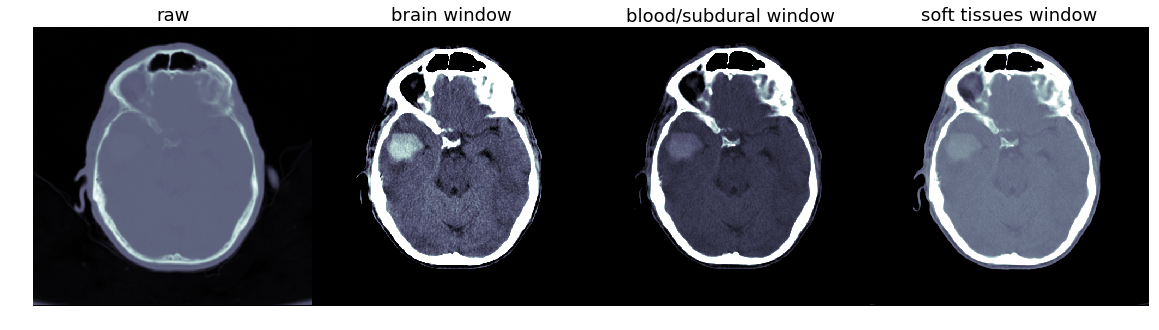

In [38]:
idx = 0

# choose the one with positive labels so that you can see the proper windowing helps focusing on the matter
row = train[train.labels != ''].iloc[idx] 
path = '../input/stage_2_train_images/%s.dcm' % row.ID

print('ID: %s' % row.ID)
print('Path: %s' % path)
print('Labels: %s' % row.labels)

dicom = pydicom.dcmread(path)
image_raw = dicom.pixel_array
image_rescaled = misc.rescale_image(image_raw, row.RescaleSlope, row.RescaleIntercept, row.BitsStored, row.PixelRepresentation)
image_windowed = apply_window_policy(image_rescaled, row, policy=4)


fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20,10))

ax0.imshow(image_raw, cmap='bone') # raw
ax0.axis('off')
ax0.set_title('raw', fontsize=18)

ax1.imshow(image_windowed[:,:,0], cmap='bone') # brain
ax1.axis('off')
ax1.set_title('brain window', fontsize=18)

ax2.imshow(image_windowed[:,:,1], cmap='bone') # blood/subdural
ax2.axis('off')
ax2.set_title('blood/subdural window', fontsize=18)

ax3.imshow(image_windowed[:,:,2], cmap='bone') # soft tissues
ax3.axis('off')
ax3.set_title('soft tissues window', fontsize=18)

plt.subplots_adjust(wspace=0, hspace=0)
#plt.show()
plt.savefig('windowing.png', bbox_inches='tight')

You can clearly see where the problem is, in this case `intraparenchymal`, after windowing.